# Demo:  Gradient Descent Optimization

In the [breast cancer demo](../logistic/breast_cancer.ipynb), we used the `sklearn` built-in `LogisticRegression` class to find the weights for the logistic regression problem.   The `fit` routine in that class has an *optimizer* to select the weights to best match the data.  To understand how that optimizer works, in this demo, we will build a very simple gradient descent optimizer from scratch.  You will learn to:
* Compute the gradients of a simple loss function and implement the gradient calculations in python
* Implement a simple gradient descent optimizer
* Visualize the effect of the learning rate in gradient descent
* Implement an adaptive learning rate algorithm

```
上个实验中用用的sklean里面的logistic模型，内部有一个optimizer帮我们找到合适的w（因为没有解析解（close-form solution），所以只能用一种优化机制来逼近结果），但是我们并不知道内部是什么优化机制（怎么选出来了这个w）。这个Demo的目的就是自己写一个optimizer来实现Optimization这个过程（用的是梯度下降的方法）```

## Loading the Breast Cancer Data

We first load the standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn import preprocessing

We next load the data from the [breast cancer demo](../logistic/breast_cancer.ipynb).  

In [2]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head()

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


As in the breast cancer demo, we create a data matrix `X` of various features of the breast cancer sample.  The response vector `y` is a binary indicating if each sample is benign or malignant.  

In [3]:
# Get the predictors
xnames = names[1:-1]#-1代表最后一个的下标，-2是倒数第二个，但是因为左开右闭，所以不包含class，如果想包含class要写成[1:],
X = np.array(df[xnames])  #X.shape  (683, 9)
Xs = preprocessing.scale(X)   #因为预先标准化了X，所以w绝对值基本都小于1

# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)    #良性细胞y=0；恶性细胞y=1
# help(preprocessing.scale)
# Xs[0:10,]

We want to learn the classification rule to predict `y` from `X`.  To this end, we first split the data into training and test.

In [4]:
ntr = 400        # number of training samples
Xtr = X[:ntr,:]  # training
ytr = y[:ntr]
Xts = X[ntr:,:]  # test
yts = y[ntr:]

## Computing the Gradient and Loss Function

Recall that training a logistic function means finding a weight vector `w` for the classification rule:

    P(y=1|x,w) = 1/(1+\exp(-z)), z = w[0] + w[1]*x[0] + ... + w[k]x[k-1]
    
From the class notes in logistic regression, we saw that the weight vector can be found by minimizing  the negative log likelihood.  The negative log likelihood is called the *loss* function.  For the logistic regression problem, the loss function simplifies to:


    f(w) = \sum_i -y[i]z[i] + ln(1+exp(z[i])),  z[i] = w[0] + w[1]X[i,0] + ... + w[k]X[i,k-1].
    
To run a numerical optimizer in python, we need to implement a python function that returns `f(w)` and its gradient.  

Since the function `f(w)` also depends parameters `X` and `y`, it is easier to implement the function as a method in a class that contains the parameters.  In the code below, we create a class `LogisticFun` where the constructor takes the parameters `X` and `y`.  Then, the class method `feval` takes a variable `w` and computes the loss and its gradient.

In [5]:
#返回loss function：f和f关于w的梯度
class LogisticFun(object):
    def __init__(self,X,y):
        """
        Class for computes the loss and gradient for a logistic regression problem.
        
        The constructor takes the data matrix `X` and response vector y for training.
        """
        self.X = X
        self.y = y
        n = X.shape[0]    #多少个sample
        self.A = np.column_stack((np.ones(n,), X)) #类似于np.hstack(()),区别是前者合并数组和矩阵，后者合并两个矩阵

    def feval(self,w):
        """
        Compute the loss and gradient for a given weight vector
        """
        # The loss is the binary cross entropy
        z = self.A.dot(w)
        py = 1/(1+np.exp(-z))
        
        #在Lecture2最后一页写了推导过程~~~
        # loss function
        f = np.sum((1-self.y)*z - np.log(py))    #log默认底数为e，log10（），log（）分别为底数为10和2
        
        # Gradient
        df_dz = py-self.y  #相当于ppt上g(z)关于z的梯度
        fgrad = self.A.T.dot(df_dz)
        return f, fgrad

Once we have defined the class we can create an *instance* of the class with the training data.

In [6]:
log_fun = LogisticFun(Xtr,ytr)

Before using the function, it is important to test if the gradient is correct.

In [7]:
# Take a random initial point
p = X.shape[1]+1   #因为A前面加了一列常数项
w0 = np.random.randn(p)  #标准正态分布取值  w0.shape  (10,)

# Perturb(扰乱) the point
step = 1e-6
w1 = w0 + step*np.random.randn(p)   #这里没用梯度下降法，用的是随机取得步长

# Measure the function and gradient at w0 and w1
f0, fgrad0 = log_fun.feval(w0)
f1, fgrad1 = log_fun.feval(w1)

# Predict the amount the function should have changed based on the gradient
df_est = fgrad0.dot(w1-w0)   #np.dot表示外积
#等价于df_estt = np.sum(fgrad0*(w1-w0))

# Print the two values to see if they are close
print("Actual f1-f0    = %12.4e" % (f1-f0))  #共12位（包括小数点和e后面的），e表示科学计数法
print("Predicted f1-f0 = %12.4e" % df_est)

Actual f1-f0    =  -6.0448e-04
Predicted f1-f0 =  -6.0448e-04


You can see that the two agree well.

You could also create the function using a technique called `lambda` calculus as shown below.  But, we will not use this.

In [20]:
# Create a function with all the parameters
def feval_param(w,X,y):
    """
    Compute the loss and gradient given w,X,y
    """
    # Construct transform matrix
    n = X.shape[0]
    A = np.column_stack((np.ones(n,), X))

    # The loss is the binary cross entropy
    z = A.dot(w)
    py = 1/(1+np.exp(-z))
    f = np.sum((1-y)*z - np.log(py))

    # Gradient
    df_dz = py-y
    fgrad = A.T.dot(df_dz)
    return f, fgrad

# Create a function with X,y fixed
feval = lambda w: feval_param(w,Xtr,ytr)   #一个匿名函数？？何必多此一举呢- -。。。。。。？

# You can now pass a parameter like w0
f0, fgrad0 = feval(w0)
# f0, fgrad0 = feval_param(w0,Xtr,ytr)

## A Simple Gradient Descent Optimizer

Now, we build a simple gradient descent optimizer function with a fixed learning rate.

In [9]:
def grad_opt_simp(feval, winit, lr=1e-3,nit=1000):
    """
    Simple gradient descent optimization
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    lr:     learning rate
    nit:    Number of iterations
    """
    # Initialize
    w0 = winit
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'w': [], 'f': []}
    
    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        f0, fgrad0 = feval(w0)

        # Take a gradient step
        w0 = w0 - lr*fgrad0   #梯度是最大增加方向，所以这里要用减号（因为要找最小的f）
        
         # Save history
        hist['f'].append(f0)   #错位了吧= =？
        hist['w'].append(w0)

    # Convert to numpy arrays  #把list转换成数组，（就俩元素还写个循环= =。。。。。。）
    for elem in ('f', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist

We now run the gradient descent starting from a random initial condition.

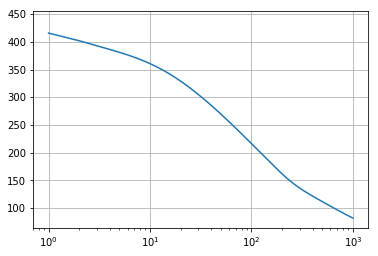

In [10]:
# Initial condition
winit = np.random.randn(p)

# Parameters
feval = log_fun.feval
nit = 1000
lr = 1e-4

# Run the gradient descent
w, f0, hist = grad_opt_simp(feval, winit, lr=lr, nit=nit)

# Plot the training loss
t = np.arange(nit)
plt.semilogx(t, hist['f'])  #一开始变化很快，后来变化很慢，所以用semilogx画图
# plt.plot(t, hist['f'])    #这个很陡
plt.grid()

We can measure the accuracy of the final estimate by creating a predict method.

In [11]:
def predict(X,w):
    z = X.dot(w[1:]) + w[0]
    yhat = (z > 0)
    return yhat

yhat = predict(Xts,w)
acc = np.mean(yhat == yts)
print("Test accuracy = %f" % acc)

Test accuracy = 0.957597


This is not quite as good as the test accuracy for the `sklearn` method, which was about 98.5%.  The reason is that the learning rate was somewhat slow and we didn't yet fully converge.

To see the effect of the learning rate, the code below tries different learning rates.

lr=    1.00e-05  Test accuracy = 0.837456
lr=    1.00e-04  Test accuracy = 0.957597
lr=    1.00e-03  Test accuracy = 0.989399


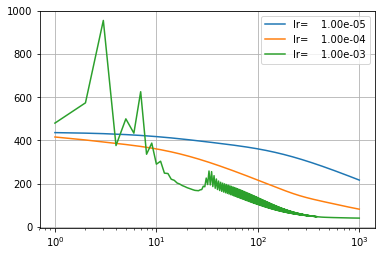

In [12]:
# Learning rate values to test
lr_test = [1e-5,1e-4,1e-3]
ntest = len(lr_test)

# Strings for the legend
leg_str = []

for i, lr in enumerate(lr_test):
    # Run the optimizer
    w, f0, hist = grad_opt_simp(feval, winit, lr=lr, nit=nit)    
    
    # Plot the results
    plt.semilogx(t, hist['f'])
    leg_str.append("lr=%12.2e" % lr)
    
    # Measure the test accuracy
    yhat = predict(Xts,w)
    acc = np.mean(yhat == yts)
    print("lr=%12.2e  Test accuracy = %f" % (lr, acc))
    
plt.grid()
plt.legend(leg_str, loc='upper right')
#lr很大时有起伏是因为有的时候可能一下子步迈过了，然后又往回迈

We see that increasing the learning rate, speeds the convergence time, but the optimization is beginning to go unstable.

## Adaptive Step Size

The above example shows that gradient descent is sensitive to the step size.  We now consider a slight variant of gradient descent with an adaptive step-size using the Armijo rule in class.

In [13]:
def grad_opt_adapt(feval, winit, nit=1000, lr_init=1e-3):
    """
    Gradient descent optimization with adaptive step size
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    nit:    Number of iterations
    lr:     Initial learning rate
    """
    
    # Set initial point
    w0 = winit
    f0, fgrad0 = feval(w0)
    lr = lr_init
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'lr': [], 'w': [], 'f': []}

    for it in range(nit):

        # Take a gradient step
        w1 = w0 - lr*fgrad0

        # Evaluate the test point by computing the objective function, f1,
        # at the test point and the predicted decrease, df_est
        f1, fgrad1 = feval(w1)
        df_est = fgrad0.dot(w1-w0)
        
        # Check if test point passes the Armijo rule
        alpha = 0.5
        if (f1-f0 < alpha*df_est) and (f1 < f0):
            # If descent is sufficient, accept the point and increase the
            # learning rate
            lr = lr*2
            f0 = f1
            fgrad0 = fgrad1
            w0 = w1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2            
            
        # Save history
        hist['f'].append(f0)
        hist['lr'].append(lr)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'lr', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist


We can now run the new optimizer.

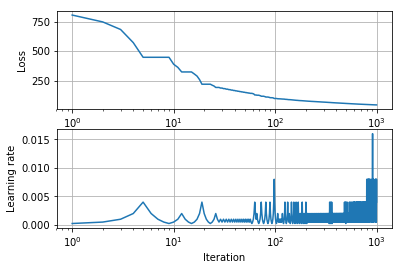

In [14]:
winit = np.random.randn(p)
nit = 1000
w, f0, hist = grad_opt_adapt(feval, winit, nit=nit)

t = np.arange(nit)
plt.subplot(2,1,1)
plt.semilogx(t, hist['f'])
plt.grid()
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.semilogx(t, hist['lr'])
plt.grid()
plt.ylabel('Learning rate')
plt.xlabel('Iteration')

Finally we measure the accuracy.

In [15]:
yhat = predict(Xts,w)
acc = np.mean(yhat == yts)
print("Test accuracy = %f" % acc)

Test accuracy = 0.989399


## In-Class Exercise

Try to a build a simple optimizer to minimize:

    f(w) = a[0] + a[1]*w + a[2]*w^2 + ... + a[d]*w^d
    
for the coefficients `a = [0,0.5,-2,0,1]`.

* Plot the function f(w)
* Can you see where the minima is?
* Write a function that outputs f(w) and its gradient.
* Run the optimizer on the function to see if it finds the minima.
* Print the funciton value and number of iterations.
* Bonus:  Instead of writing the function for a specific coefficient vector `a`, create a class that works for an arbitrary vector `a`.

You may wish to use the `poly.polyval(w,a)` method to evaluate the polynomial.

In [16]:
import numpy.polynomial.polynomial as poly


